<a href="https://colab.research.google.com/github/jperdomos/TeoriaAprendizajeDeMaquina/blob/main/Soluci%C3%B3n_CVClasificacion_LFW_JP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [ ]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


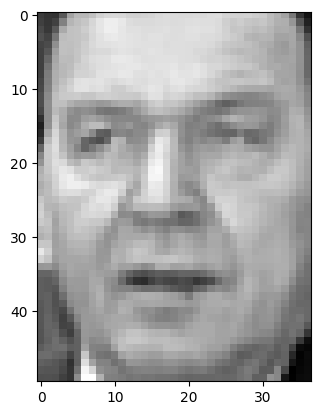

In [ ]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [ ]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [ ]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [ ]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


np.float64(0.43286065070595453)

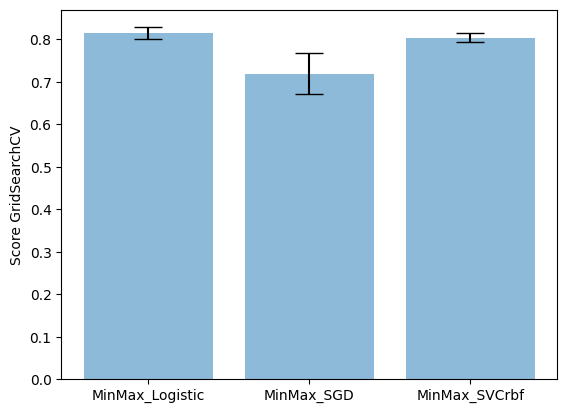

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.719 0.804]
 [0.014 0.048 0.011]]


In [ ]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/3)


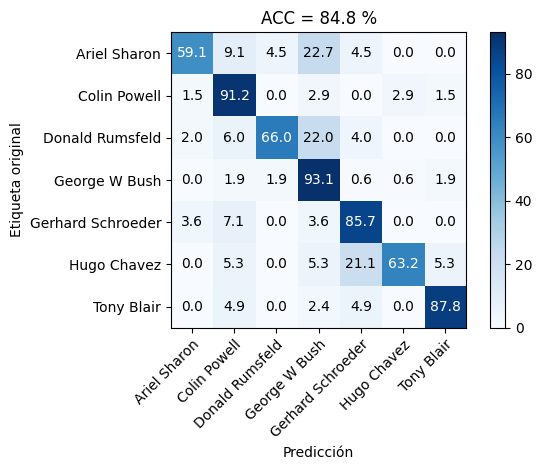

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


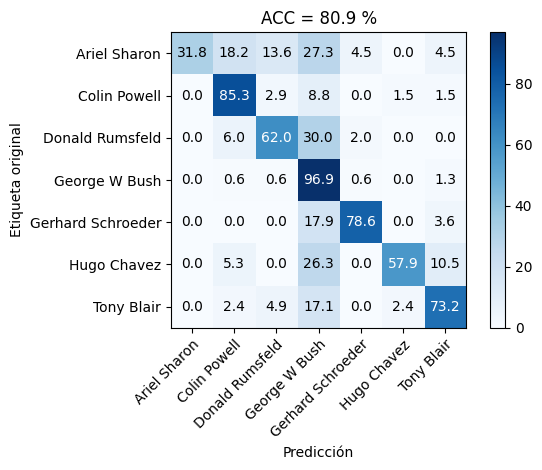

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.32      0.48        22
     Colin Powell       0.85      0.85      0.85        68
  Donald Rumsfeld       0.79      0.62      0.70        50
    George W Bush       0.78      0.97      0.86       159
Gerhard Schroeder       0.88      0.79      0.83        28
      Hugo Chavez       0.85      0.58      0.69        19
       Tony Blair       0.81      0.73      0.77        41

         accuracy                           0.81       387
        macro avg       0.85      0.69      0.74       387
     weighted avg       0.82      0.81      0.80       387

Evaluando modelo MinMax_SVCrbf (3/3)


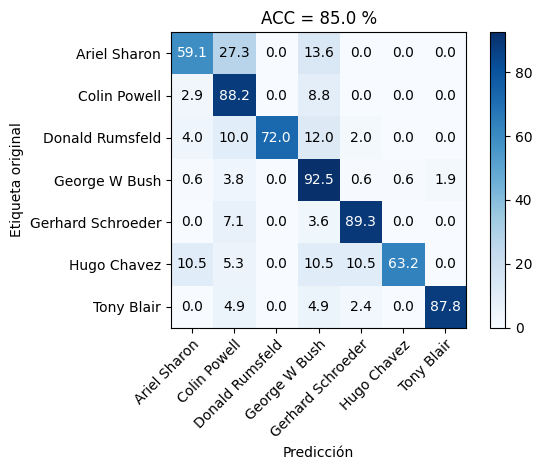

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [ ]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


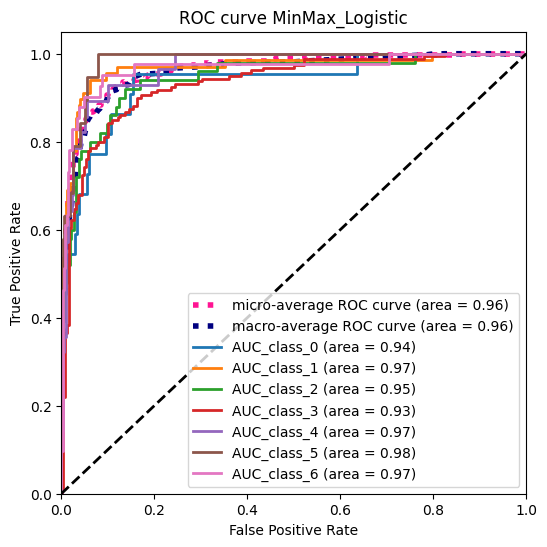

Evaluando modelo MinMax_SGD (2/3)


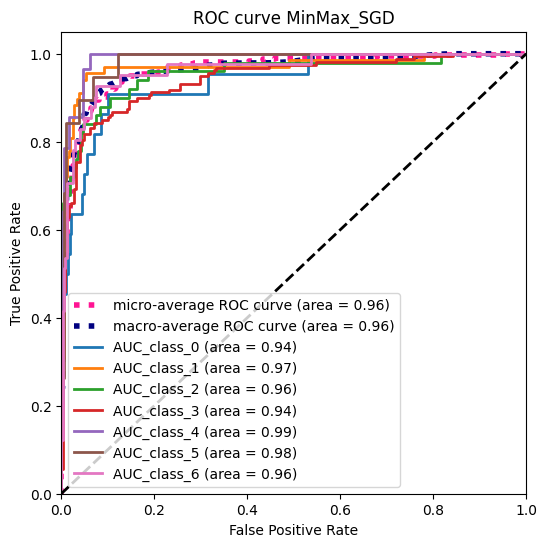

Evaluando modelo MinMax_SVCrbf (3/3)


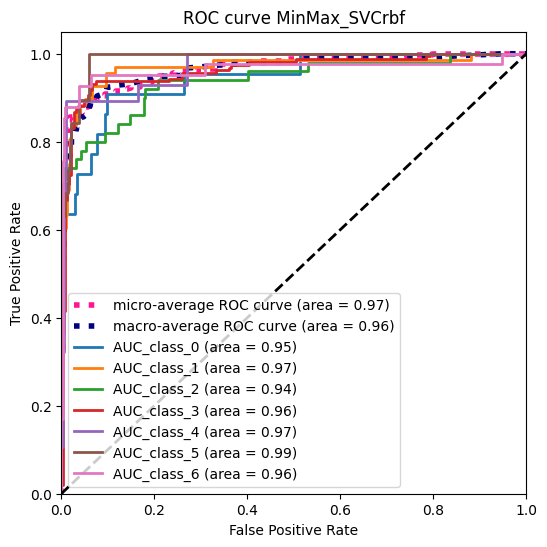

In [ ]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1. Emplee optimización Bayesiana de hiperparámetros, fijando el score en términos del acc, el f1 y el AUC.


#Solución - Juan Camilo Perdomo Soto

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 26.0 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pprint


In [ ]:
def objective_logreg(trial):
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    pipe = Pipeline([("scaler", MinMaxScaler()), ("clf", LogisticRegression(C=C, max_iter=1000))])
    return cross_val_score(pipe, Xtrain, ytrain, cv=5, scoring="accuracy", n_jobs=-1).mean()

def objective_sgd(trial):
    alpha = trial.suggest_loguniform("alpha", 1e-5, 1e1)
    pipe = Pipeline([("scaler", MinMaxScaler()), ("clf", SGDClassifier(alpha=alpha, max_iter=1000, tol=1e-3))])
    return cross_val_score(pipe, Xtrain, ytrain, cv=5, scoring="f1_macro", n_jobs=-1).mean()

def objective_knn(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 3, 15)
    pipe = Pipeline([("scaler", MinMaxScaler()), ("clf", KNeighborsClassifier(n_neighbors=n_neighbors))])
    return cross_val_score(pipe, Xtrain, ytrain, cv=5, scoring="accuracy", n_jobs=-1).mean()

def objective_lda(trial):
    pipe = Pipeline([("scaler", MinMaxScaler()), ("clf", LinearDiscriminantAnalysis())])
    return cross_val_score(pipe, Xtrain, ytrain, cv=5, scoring="accuracy", n_jobs=-1).mean()

def objective_linearsvc(trial):
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    pipe = Pipeline([("scaler", MinMaxScaler()), ("clf", LinearSVC(C=C, max_iter=10000))])
    return cross_val_score(pipe, Xtrain, ytrain, cv=5, scoring="f1_macro", n_jobs=-1).mean()

def objective_svc(trial):
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    gamma = trial.suggest_loguniform("gamma", 1e-4, 1e1)
    pipe = Pipeline([("scaler", MinMaxScaler()), ("clf", SVC(C=C, gamma=gamma))])
    return cross_val_score(pipe, Xtrain, ytrain, cv=5, scoring="accuracy", n_jobs=-1).mean()

def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    pipe = Pipeline([("scaler", MinMaxScaler()), ("clf", RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth))])
    return cross_val_score(pipe, Xtrain, ytrain, cv=5, scoring="accuracy", n_jobs=-1).mean()

def objective_nb(trial):
    pipe = Pipeline([("scaler", MinMaxScaler()), ("clf", GaussianNB())])
    return cross_val_score(pipe, Xtrain, ytrain, cv=5, scoring="accuracy", n_jobs=-1).mean()


In [ ]:
model_names = [
    "Logistic Regression", "SGD", "KNN", "LDA", "LinearSVC",
    "SVC-RBF", "Random Forest", "GaussianNB"
]

objectives = [
    objective_logreg, objective_sgd, objective_knn, objective_lda,
    objective_linearsvc, objective_svc, objective_rf, objective_nb
]

scores = []



In [ ]:
study_logreg = optuna.create_study(direction="maximize")
study_logreg.optimize(objective_logreg, n_trials=30)

print(" Logistic Regression")
print("  Mejor score CV:", study_logreg.best_value)
print("  Mejores hiperparámetros:")
pprint.pprint(study_logreg.best_params)


[I 2025-06-12 01:00:04,633] A new study created in memory with name: no-name-b972ef70-41d2-44ec-af88-abde63401c9b
[I 2025-06-12 01:00:10,982] Trial 0 finished with value: 0.810196439533456 and parameters: {'C': 31.17021403697968}. Best is trial 0 with value: 0.810196439533456.
[I 2025-06-12 01:00:25,115] Trial 1 finished with value: 0.5061264579496624 and parameters: {'C': 0.0033132215651514806}. Best is trial 0 with value: 0.810196439533456.
[I 2025-06-12 01:00:28,988] Trial 2 finished with value: 0.8113198281154081 and parameters: {'C': 138.94879710777354}. Best is trial 2 with value: 0.8113198281154081.
[I 2025-06-12 01:00:39,261] Trial 3 finished with value: 0.6548557397176181 and parameters: {'C': 0.016449700080071177}. Best is trial 2 with value: 0.8113198281154081.
[I 2025-06-12 01:00:43,489] Trial 4 finished with value: 0.8057642725598526 and parameters: {'C': 98.95553193250467}. Best is trial 2 with value: 0.8113198281154081.
[I 2025-06-12 01:00:49,842] Trial 5 finished with v

 Logistic Regression
  Mejor score CV: 0.8168508287292816
  Mejores hiperparámetros:
{'C': 0.8212383175856353}


In [ ]:
study_sgd = optuna.create_study(direction="maximize")
study_sgd.optimize(objective_sgd, n_trials=30)

print(" SGDClassifier")
print("  Mejor score CV:", study_sgd.best_value)
pprint.pprint(study_sgd.best_params)


[I 2025-06-12 01:05:16,236] A new study created in memory with name: no-name-1262a40b-b16a-422b-8557-5209b900e94d
[I 2025-06-12 01:05:18,537] Trial 0 finished with value: 0.6966621477855791 and parameters: {'alpha': 0.016309613008532786}. Best is trial 0 with value: 0.6966621477855791.
[I 2025-06-12 01:05:20,325] Trial 1 finished with value: 0.41801447568714006 and parameters: {'alpha': 0.30044535288082436}. Best is trial 0 with value: 0.6966621477855791.
[I 2025-06-12 01:05:21,870] Trial 2 finished with value: 0.3518606783038388 and parameters: {'alpha': 0.5282269077072258}. Best is trial 0 with value: 0.6966621477855791.
[I 2025-06-12 01:05:23,589] Trial 3 finished with value: 0.3902618438281368 and parameters: {'alpha': 0.29331355700464357}. Best is trial 0 with value: 0.6966621477855791.
[I 2025-06-12 01:05:24,595] Trial 4 finished with value: 0.22140876534777137 and parameters: {'alpha': 3.9981305752121052}. Best is trial 0 with value: 0.6966621477855791.
[I 2025-06-12 01:05:25,48

 SGDClassifier
  Mejor score CV: 0.7358074627414193
{'alpha': 0.00027336127230579896}


In [ ]:
study_knn = optuna.create_study(direction="maximize")
study_knn.optimize(objective_knn, n_trials=30)

print(" KNN")
print("  Mejor score CV:", study_knn.best_value)
pprint.pprint(study_knn.best_params)


[I 2025-06-12 01:06:21,545] A new study created in memory with name: no-name-fa8e6727-906a-4c45-9979-fe01c77fe4c3
[I 2025-06-12 01:06:21,969] Trial 0 finished with value: 0.552756292203806 and parameters: {'n_neighbors': 11}. Best is trial 0 with value: 0.552756292203806.
[I 2025-06-12 01:06:22,333] Trial 1 finished with value: 0.5538489871086556 and parameters: {'n_neighbors': 5}. Best is trial 1 with value: 0.5538489871086556.
[I 2025-06-12 01:06:22,684] Trial 2 finished with value: 0.552744014732965 and parameters: {'n_neighbors': 9}. Best is trial 1 with value: 0.5538489871086556.
[I 2025-06-12 01:06:23,034] Trial 3 finished with value: 0.5549785144260282 and parameters: {'n_neighbors': 6}. Best is trial 3 with value: 0.5549785144260282.
[I 2025-06-12 01:06:23,405] Trial 4 finished with value: 0.5549785144260282 and parameters: {'n_neighbors': 6}. Best is trial 3 with value: 0.5549785144260282.
[I 2025-06-12 01:06:23,747] Trial 5 finished with value: 0.5383118477593616 and paramete

 KNN
  Mejor score CV: 0.5616206261510129
{'n_neighbors': 7}


In [ ]:
study_lda = optuna.create_study(direction="maximize")
study_lda.optimize(objective_lda, n_trials=30)

print(" LDA")
print("  Mejor score CV:", study_lda.best_value)
pprint.pprint(study_lda.best_params)


[I 2025-06-12 01:06:32,436] A new study created in memory with name: no-name-d6177de5-f248-4f94-90fe-83aec203b4f0
[I 2025-06-12 01:06:34,945] Trial 0 finished with value: 0.7069551872314304 and parameters: {}. Best is trial 0 with value: 0.7069551872314304.
[I 2025-06-12 01:06:36,645] Trial 1 finished with value: 0.7069551872314304 and parameters: {}. Best is trial 0 with value: 0.7069551872314304.
[I 2025-06-12 01:06:38,303] Trial 2 finished with value: 0.7069551872314304 and parameters: {}. Best is trial 0 with value: 0.7069551872314304.
[I 2025-06-12 01:06:39,957] Trial 3 finished with value: 0.7069551872314304 and parameters: {}. Best is trial 0 with value: 0.7069551872314304.
[I 2025-06-12 01:06:41,637] Trial 4 finished with value: 0.7069551872314304 and parameters: {}. Best is trial 0 with value: 0.7069551872314304.
[I 2025-06-12 01:06:43,364] Trial 5 finished with value: 0.7069551872314304 and parameters: {}. Best is trial 0 with value: 0.7069551872314304.
[I 2025-06-12 01:06:45

 LDA
  Mejor score CV: 0.7069551872314304
{}


In [ ]:
study_linearsvc = optuna.create_study(direction="maximize")
study_linearsvc.optimize(objective_linearsvc, n_trials=30)

print(" LinearSVC")
print("  Mejor score CV:", study_linearsvc.best_value)
pprint.pprint(study_linearsvc.best_params)


[I 2025-06-12 01:07:28,169] A new study created in memory with name: no-name-50ce4740-44c9-4259-bee5-e491cf1efa46
[I 2025-06-12 01:07:31,274] Trial 0 finished with value: 0.45182103509220967 and parameters: {'C': 0.001809197854312064}. Best is trial 0 with value: 0.45182103509220967.
[I 2025-06-12 01:07:37,251] Trial 1 finished with value: 0.6623503667272567 and parameters: {'C': 0.005452028143010536}. Best is trial 1 with value: 0.6623503667272567.
[I 2025-06-12 01:07:48,212] Trial 2 finished with value: 0.7438028730096526 and parameters: {'C': 0.01206861766620888}. Best is trial 2 with value: 0.7438028730096526.
[I 2025-06-12 01:07:58,979] Trial 3 finished with value: 0.7344885844035399 and parameters: {'C': 0.011095208307079439}. Best is trial 2 with value: 0.7438028730096526.
[I 2025-06-12 01:10:05,433] Trial 4 finished with value: 0.7682193938395322 and parameters: {'C': 248.60714332069472}. Best is trial 4 with value: 0.7682193938395322.
[I 2025-06-12 01:10:34,013] Trial 5 finish

 LinearSVC
  Mejor score CV: 0.7873503353148342
{'C': 0.07668638120930782}


In [ ]:
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=30)

print(" Random Forest")
print("  Mejor score CV:", study_rf.best_value)
pprint.pprint(study_rf.best_params)


[I 2025-06-12 01:36:00,375] A new study created in memory with name: no-name-f8322a86-6d4d-4184-a9e4-6d63c59e6209
[I 2025-06-12 01:36:14,589] Trial 0 finished with value: 0.612658072437078 and parameters: {'n_estimators': 165, 'max_depth': 11}. Best is trial 0 with value: 0.612658072437078.
[I 2025-06-12 01:36:27,045] Trial 1 finished with value: 0.6082627378759976 and parameters: {'n_estimators': 138, 'max_depth': 26}. Best is trial 0 with value: 0.612658072437078.
[I 2025-06-12 01:36:33,470] Trial 2 finished with value: 0.5949171270718232 and parameters: {'n_estimators': 77, 'max_depth': 26}. Best is trial 0 with value: 0.612658072437078.
[I 2025-06-12 01:36:42,951] Trial 3 finished with value: 0.5738367096378146 and parameters: {'n_estimators': 125, 'max_depth': 7}. Best is trial 0 with value: 0.612658072437078.
[I 2025-06-12 01:36:54,861] Trial 4 finished with value: 0.5549600982197667 and parameters: {'n_estimators': 183, 'max_depth': 6}. Best is trial 0 with value: 0.612658072437

 Random Forest
  Mejor score CV: 0.612694904849601
{'max_depth': 19, 'n_estimators': 168}


In [ ]:
study_nb = optuna.create_study(direction="maximize")
study_nb.optimize(objective_nb, n_trials=30)

print(" GaussianNB")
print("  Mejor score CV:", study_nb.best_value)
pprint.pprint(study_nb.best_params)


[I 2025-06-12 01:42:27,911] A new study created in memory with name: no-name-b24bf5ca-4c93-4ac1-9104-649729d55252
[I 2025-06-12 01:42:28,277] Trial 0 finished with value: 0.3762492326580724 and parameters: {}. Best is trial 0 with value: 0.3762492326580724.
[I 2025-06-12 01:42:28,618] Trial 1 finished with value: 0.3762492326580724 and parameters: {}. Best is trial 0 with value: 0.3762492326580724.
[I 2025-06-12 01:42:28,957] Trial 2 finished with value: 0.3762492326580724 and parameters: {}. Best is trial 0 with value: 0.3762492326580724.
[I 2025-06-12 01:42:29,320] Trial 3 finished with value: 0.3762492326580724 and parameters: {}. Best is trial 0 with value: 0.3762492326580724.
[I 2025-06-12 01:42:29,660] Trial 4 finished with value: 0.3762492326580724 and parameters: {}. Best is trial 0 with value: 0.3762492326580724.
[I 2025-06-12 01:42:30,003] Trial 5 finished with value: 0.3762492326580724 and parameters: {}. Best is trial 0 with value: 0.3762492326580724.
[I 2025-06-12 01:42:30

 GaussianNB
  Mejor score CV: 0.3762492326580724
{}


In [ ]:
study_svc = optuna.create_study(direction="maximize")
study_svc.optimize(objective_svc, n_trials=30)

print(" SVC (RBF)")
print("  Mejor score CV:", study_svc.best_value)
pprint.pprint(study_svc.best_params)


[I 2025-06-12 01:49:20,307] A new study created in memory with name: no-name-7f748899-c280-42a2-9a3a-3e99c3ba8f57
[I 2025-06-12 01:49:28,505] Trial 0 finished with value: 0.7314303253529773 and parameters: {'C': 12.899037268850357, 'gamma': 0.0006184431105749466}. Best is trial 0 with value: 0.7314303253529773.
[I 2025-06-12 01:49:31,720] Trial 1 finished with value: 0.8080110497237568 and parameters: {'C': 8.223664014002447, 'gamma': 0.0038141654629697025}. Best is trial 1 with value: 0.8080110497237568.
[I 2025-06-12 01:49:36,171] Trial 2 finished with value: 0.411767955801105 and parameters: {'C': 2.6477838647940235, 'gamma': 0.00021057677836499965}. Best is trial 1 with value: 0.8080110497237568.
[I 2025-06-12 01:49:41,671] Trial 3 finished with value: 0.411767955801105 and parameters: {'C': 187.3887459095575, 'gamma': 0.8131415959624232}. Best is trial 1 with value: 0.8080110497237568.
[I 2025-06-12 01:49:47,239] Trial 4 finished with value: 0.4794843462246777 and parameters: {'C'

 SVC (RBF)
  Mejor score CV: 0.8080110497237568
{'C': 8.223664014002447, 'gamma': 0.0038141654629697025}


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarizar ytest para ROC-AUC
ytest_binarized = label_binarize(ytest, classes=range(len(lfw_people.target_names)))

model_optuna = {
    "LogisticRegression": study_logreg.best_trial.params,
    "SGD": study_sgd.best_trial.params,
    "KNN": study_knn.best_trial.params,
    "LDA": {},
    "LinearSVC": study_linearsvc.best_trial.params,
    "RandomForest": study_rf.best_trial.params,
    "GaussianNB": {},
}


from sklearn.pipeline import make_pipeline

model_instances = {
    "LogisticRegression": make_pipeline(MinMaxScaler(), LogisticRegression(**study_logreg.best_params)),
    "SGD": make_pipeline(MinMaxScaler(), SGDClassifier(**study_sgd.best_params)),
    "KNN": make_pipeline(MinMaxScaler(), KNeighborsClassifier(**study_knn.best_params)),
    "LDA": make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis()),
    "LinearSVC": make_pipeline(MinMaxScaler(), LinearSVC(**study_linearsvc.best_params)),
    "SVC": make_pipeline(MinMaxScaler(), SVC(**study_svc.best_params, probability=True)),  # importante para AUC
    "RandomForest": make_pipeline(MinMaxScaler(), RandomForestClassifier(**study_rf.best_params)),
    "GaussianNB": make_pipeline(MinMaxScaler(), GaussianNB())
}

# Evaluar cada modelo
for name, model in model_instances.items():
    print(f"\n Evaluando modelo: {name}")
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)

    acc = accuracy_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred, average='macro')

    try:
        if hasattr(model[-1], "predict_proba"):
            y_score = model.predict_proba(Xtest)
        elif hasattr(model[-1], "decision_function"):
            y_score = model.decision_function(Xtest)
        else:
            raise ValueError("Modelo no compatible con AUC")
        auc_score = roc_auc_score(ytest_binarized, y_score, multi_class="ovo", average="weighted")
    except Exception as e:
        auc_score = "N/A"
        print(f" No se pudo calcular AUC para {name}: {e}")

    print(f" Accuracy: {acc:.4f}")
    print(f" F1-macro: {f1:.4f}")
    print(f" AUC (ovo weighted): {auc_score}")



 Evaluando modelo: LogisticRegression
 Accuracy: 0.8527
 F1-macro: 0.8037
 AUC (ovo weighted): 0.9741137265415297

 Evaluando modelo: SGD
 Accuracy: 0.7804
 F1-macro: 0.7118
 AUC (ovo weighted): 0.9570472119553937

 Evaluando modelo: KNN
 Accuracy: 0.5943
 F1-macro: 0.4478
 AUC (ovo weighted): 0.8147986770398264

 Evaluando modelo: LDA
 Accuracy: 0.7003
 F1-macro: 0.6384
 AUC (ovo weighted): 0.9086474285189474

 Evaluando modelo: LinearSVC
 Accuracy: 0.8656
 F1-macro: 0.8305
 AUC (ovo weighted): 0.9581155592065583

 Evaluando modelo: SVC
 Accuracy: 0.8708
 F1-macro: 0.8290
 AUC (ovo weighted): 0.9802726138656261

 Evaluando modelo: RandomForest
 Accuracy: 0.6202
 F1-macro: 0.4291
 AUC (ovo weighted): 0.9223855780494691

 Evaluando modelo: GaussianNB
 Accuracy: 0.4031
 F1-macro: 0.3811
 AUC (ovo weighted): 0.7568824538430409



 MATRIZ DE CONFUSIÓN: LogisticRegression


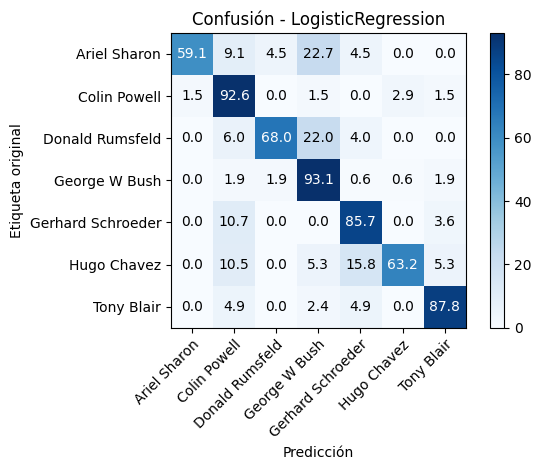

 Reporte de clasificación:
                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.59      0.72        22
     Colin Powell       0.81      0.93      0.86        68
  Donald Rumsfeld       0.89      0.68      0.77        50
    George W Bush       0.89      0.93      0.91       159
Gerhard Schroeder       0.73      0.86      0.79        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.86      0.88      0.87        41

         accuracy                           0.85       387
        macro avg       0.84      0.78      0.80       387
     weighted avg       0.86      0.85      0.85       387


 MATRIZ DE CONFUSIÓN: SGD


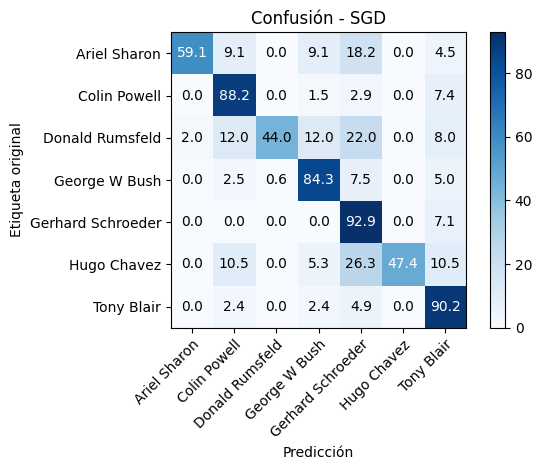

 Reporte de clasificación:
                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.59      0.72        22
     Colin Powell       0.80      0.88      0.84        68
  Donald Rumsfeld       0.96      0.44      0.60        50
    George W Bush       0.92      0.84      0.88       159
Gerhard Schroeder       0.42      0.93      0.58        28
      Hugo Chavez       1.00      0.47      0.64        19
       Tony Blair       0.63      0.90      0.74        41

         accuracy                           0.78       387
        macro avg       0.81      0.72      0.72       387
     weighted avg       0.84      0.78      0.78       387


 MATRIZ DE CONFUSIÓN: KNN


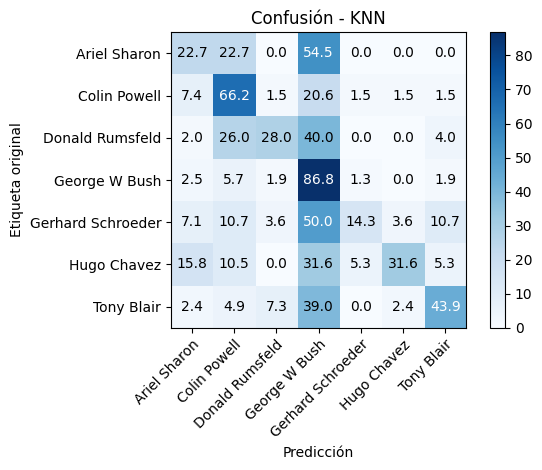

 Reporte de clasificación:
                   precision    recall  f1-score   support

     Ariel Sharon       0.24      0.23      0.23        22
     Colin Powell       0.57      0.66      0.61        68
  Donald Rumsfeld       0.64      0.28      0.39        50
    George W Bush       0.63      0.87      0.73       159
Gerhard Schroeder       0.50      0.14      0.22        28
      Hugo Chavez       0.67      0.32      0.43        19
       Tony Blair       0.64      0.44      0.52        41

         accuracy                           0.59       387
        macro avg       0.55      0.42      0.45       387
     weighted avg       0.59      0.59      0.56       387


 MATRIZ DE CONFUSIÓN: LDA


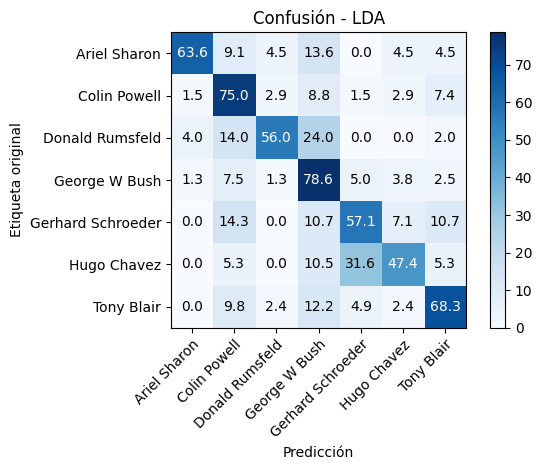

 Reporte de clasificación:
                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.64      0.68        22
     Colin Powell       0.63      0.75      0.68        68
  Donald Rumsfeld       0.82      0.56      0.67        50
    George W Bush       0.80      0.79      0.79       159
Gerhard Schroeder       0.48      0.57      0.52        28
      Hugo Chavez       0.43      0.47      0.45        19
       Tony Blair       0.65      0.68      0.67        41

         accuracy                           0.70       387
        macro avg       0.65      0.64      0.64       387
     weighted avg       0.71      0.70      0.70       387


 MATRIZ DE CONFUSIÓN: LinearSVC


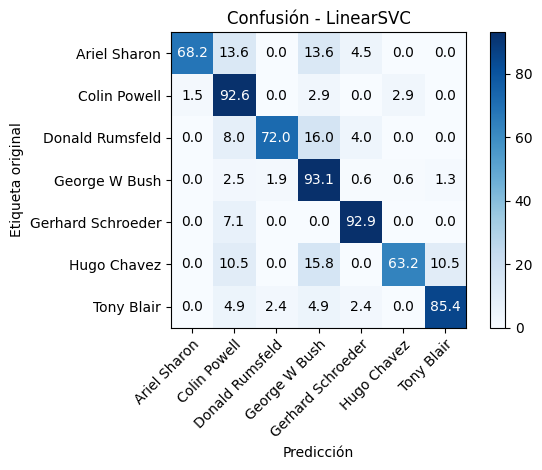

 Reporte de clasificación:
                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.68      0.79        22
     Colin Powell       0.79      0.93      0.85        68
  Donald Rumsfeld       0.90      0.72      0.80        50
    George W Bush       0.89      0.93      0.91       159
Gerhard Schroeder       0.84      0.93      0.88        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.90      0.85      0.88        41

         accuracy                           0.87       387
        macro avg       0.86      0.81      0.83       387
     weighted avg       0.87      0.87      0.86       387


 MATRIZ DE CONFUSIÓN: SVC


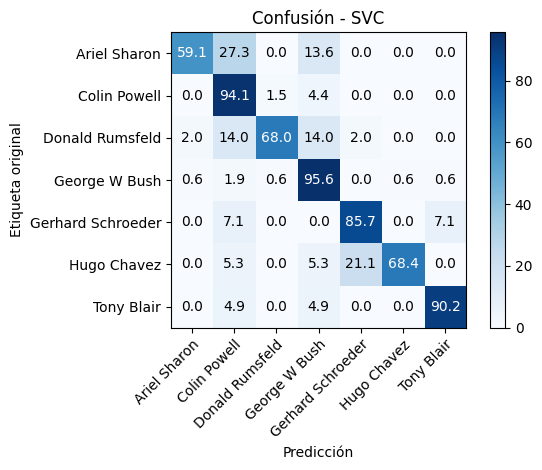

 Reporte de clasificación:
                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.59      0.70        22
     Colin Powell       0.75      0.94      0.84        68
  Donald Rumsfeld       0.94      0.68      0.79        50
    George W Bush       0.90      0.96      0.93       159
Gerhard Schroeder       0.83      0.86      0.84        28
      Hugo Chavez       0.93      0.68      0.79        19
       Tony Blair       0.93      0.90      0.91        41

         accuracy                           0.87       387
        macro avg       0.88      0.80      0.83       387
     weighted avg       0.88      0.87      0.87       387


 MATRIZ DE CONFUSIÓN: RandomForest


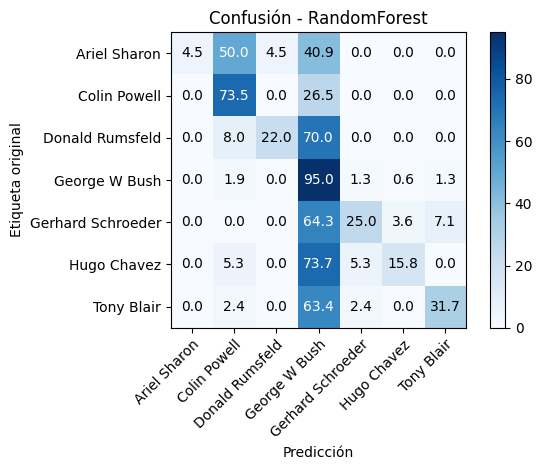

 Reporte de clasificación:
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.05      0.09        22
     Colin Powell       0.71      0.74      0.72        68
  Donald Rumsfeld       0.92      0.22      0.35        50
    George W Bush       0.56      0.95      0.70       159
Gerhard Schroeder       0.64      0.25      0.36        28
      Hugo Chavez       0.60      0.16      0.25        19
       Tony Blair       0.76      0.32      0.45        41

         accuracy                           0.61       387
        macro avg       0.74      0.38      0.42       387
     weighted avg       0.69      0.61      0.55       387


 MATRIZ DE CONFUSIÓN: GaussianNB


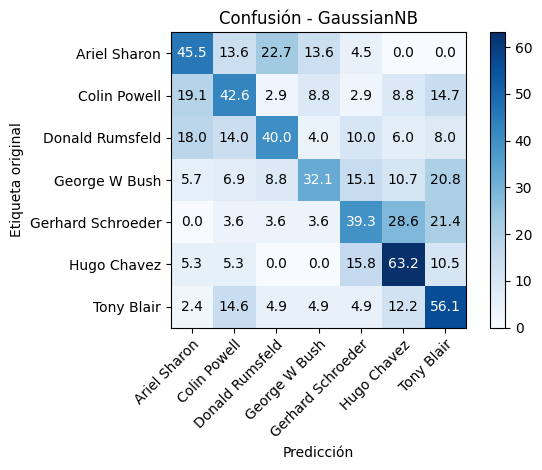

 Reporte de clasificación:
                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387



In [ ]:
from sklearn.metrics import classification_report

for name, model in model_instances.items():
    print(f"\n MATRIZ DE CONFUSIÓN: {name}")
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)

    plot_confusion_matrix(
        ytest, y_pred,
        classes=lfw_people.target_names,
        title=f"Confusión - {name}"
    )
    plt.show()

    print(" Reporte de clasificación:")
    print(classification_report(
        ytest, y_pred,
        target_names=lfw_people.target_names
    ))



 Curva ROC: LogisticRegression


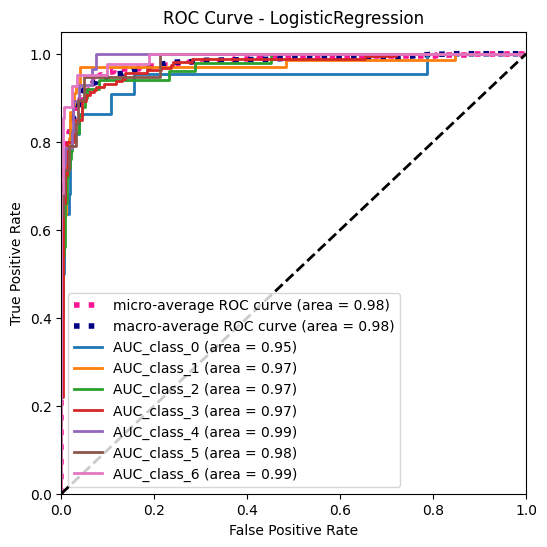


 Curva ROC: SGD


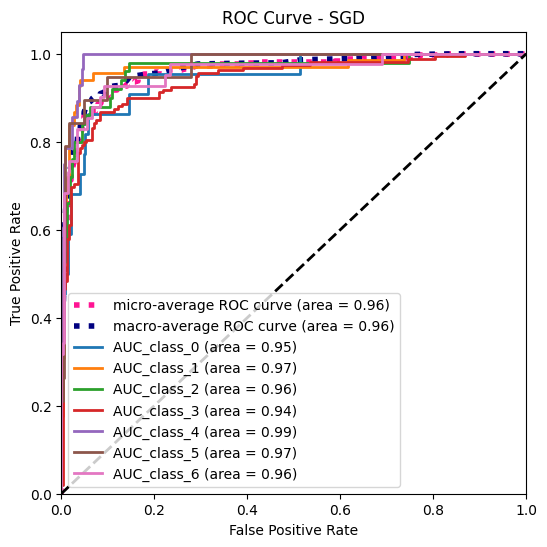


 Curva ROC: KNN


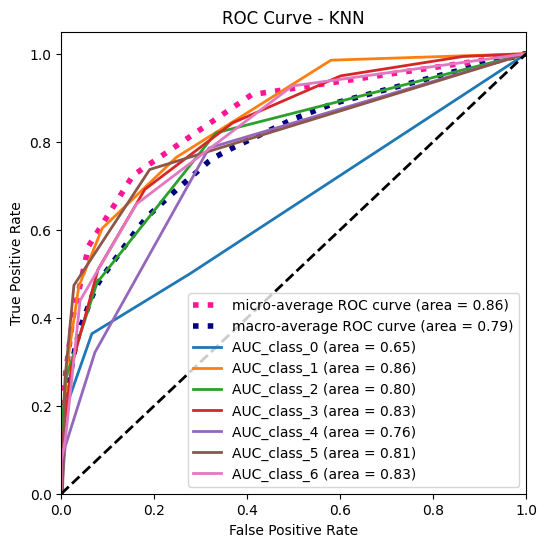


 Curva ROC: LDA


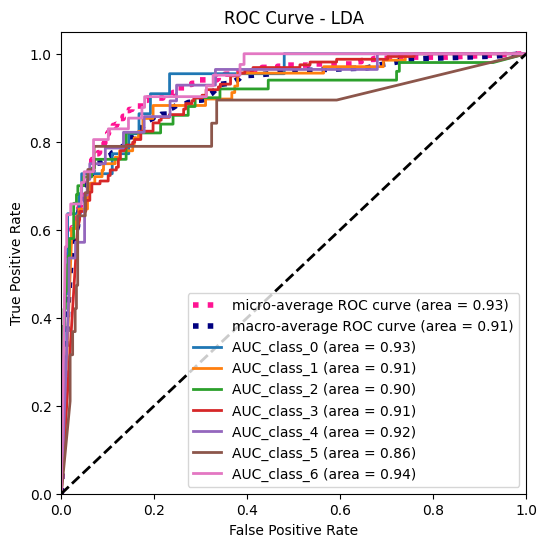


 Curva ROC: LinearSVC


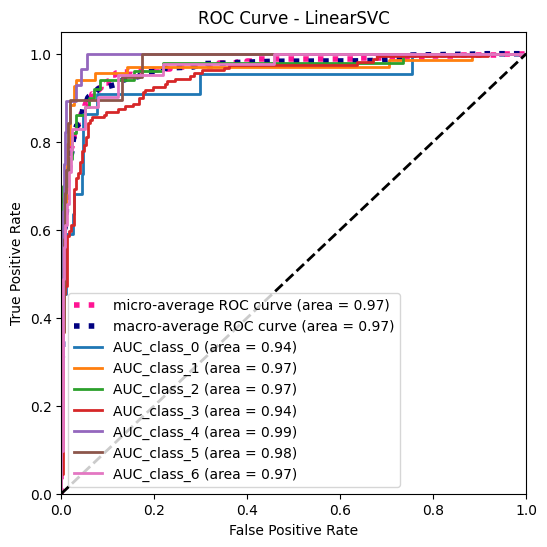


 Curva ROC: SVC


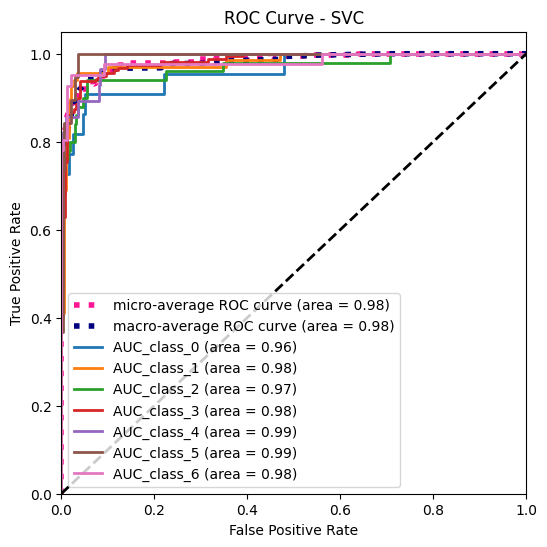


 Curva ROC: RandomForest


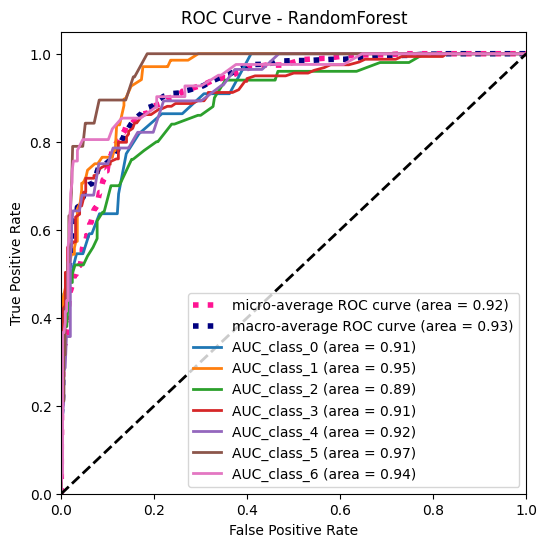


 Curva ROC: GaussianNB


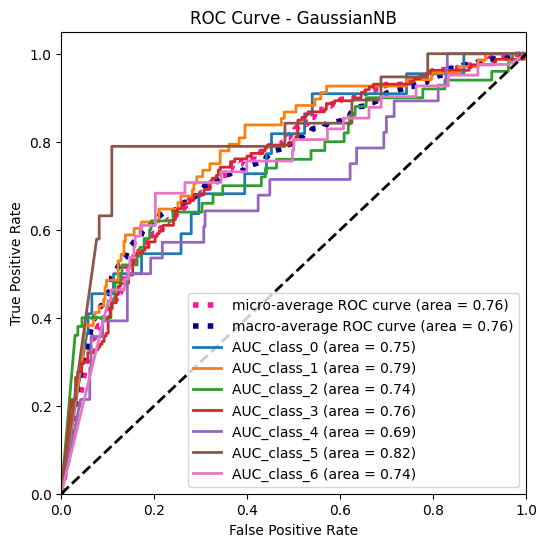

In [ ]:
for name, model in model_instances.items():
    print(f"\n Curva ROC: {name}")
    try:
        model.fit(Xtrain, ytrain)

        if hasattr(model[-1], "predict_proba"):
            y_score = model.predict_proba(Xtest)
        elif hasattr(model[-1], "decision_function"):
            y_score = model.decision_function(Xtest)
        else:
            print(f" No se puede graficar ROC para {name} (no tiene scores)")
            continue

        roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_binarized, y_score)
        roc_auc_mc(roc_auc, fpr, tpr, n_classes, f"ROC Curve - {name}", path_img="")

    except Exception as e:
        print(f" Error al generar ROC para {name}: {e}")
